## Quora Question Pairs

#### In this task for a given user query, I had to find which is the most similar question from the given set of questions. A system which will be able to give top-3 question suggestions for the given query.

<b><a href="http://qim.fs.quoracdn.net/quora_duplicate_questions.tsv">DataSet Link</a></b>

<img src="pipeline.png" alt="Italian Trulli">

I started by importing the necessary libraries. `re` was used for preprocessing the text of the data, removing unwanted characters or noise from the data. `Pandas` is used for reading the data in a row and column format binding it in a dataframe. `Matplotlib` was used for plotting the statistics of the data. To visualise the plots within jupyter notebook `%matplotlib inline` was added. `Pickle` was used to save the modified dataframes, vocabulary and embeddings of the data, so that it can be later reused by just loading the specific pickle file. `BeautifulSoup` was imported for removing any kind of *HTML* tags if present in the data. `Numpy` was imported to handle multi-dimensional arrays and since the input, output, predictions from the model were an array, numpy was quite useful. Then, I imported `NLTK` a natural language processing toolkit to remove stopwords from the data like *if, or, him* etc. which does not give any important information. `Gensim` library was imported to load Google's `Word2Vec` which converted each of the word in to a 300 dimensional vector.

**Note**: I did not use stemming, since stemming usually takes each word to its root and sometimes that root word is not there in the pre-trained word2vec models. 

The below libraries were imported as and when they were required I collated them to one cell. There are many other libraries that were used which I have not put in this cell and you will find them in later sections as the implementation proceeds.

In [2]:
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from bs4 import BeautifulSoup
import numpy as np                                                                
import nltk                                      
nltk.download('stopwords')
from nltk.corpus import stopwords                                
from gensim.models import KeyedVectors

[nltk_data] Downloading package stopwords to
[nltk_data]     /users/aditya.sharma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Loading the data

In [3]:
url="http://qim.fs.quoracdn.net/quora_duplicate_questions.tsv"
original_data=pd.read_csv(url,error_bad_lines=False,sep='\t')

#### Output first few rows of the data to see how it looks like. As per my observation, we need three columns for this task namely *question1*, *question2* and *is_duplicate*.

In [4]:
original_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


Check if there are any `null` values in the dataset!

In [5]:
original_data.isnull().values.sum()

3

Dropped the three null values!

In [6]:
original_data = original_data.dropna()

In [7]:
original_data.shape

(404287, 6)

Since I will need the `original_data` later on, I copy it into a new variable called `data`.

In [8]:
data = original_data.copy()

In [9]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


#### Check for data imbalancing!

In [168]:
print (data[data.is_duplicate == 1].count())

id              149263
qid1            149263
qid2            149263
question1       149263
question2       149263
is_duplicate    149263
dtype: int64


As per my observation this dataset doesn't have data imbalancing issue, since both the classes have if not equal but fair amount of records in each class. The class label `0` has around 250K records whereas class label `1` has around 150K records.

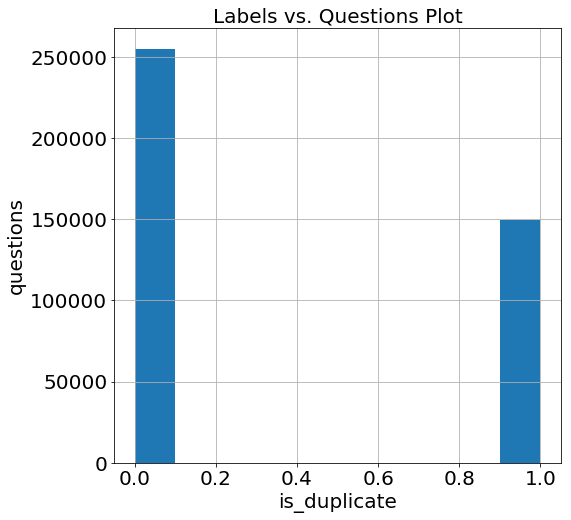

In [169]:
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
data['is_duplicate'].hist(ax=ax)
plt.xlabel('is_duplicate',fontsize=20)
plt.ylabel('questions',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Labels vs. Questions Plot',fontsize=20)
plt.show()

Below are the stopwords that are there in the `nltk` library which will be removed from the dataset.

In [170]:
stop = set(stopwords.words('english')) 
print(stop)

{'she', 'when', 'has', 'once', "couldn't", 'my', "doesn't", 'as', 'can', 'hers', 'own', 'that', 'shouldn', 'not', 'shan', "you'll", 'are', 'doing', 'ours', 'under', "haven't", 'hasn', "hasn't", 'who', 'they', 'weren', 'he', 'll', 'them', 'how', 'am', 'didn', 'or', "mustn't", 'him', 'itself', 'now', "it's", "mightn't", 'a', 'until', 'up', 'myself', 'aren', 'we', 'into', 'below', 'been', 'should', 'during', "wouldn't", "weren't", 'there', 'mustn', 'of', 'with', 'himself', 'off', 'any', 'against', 'further', 'herself', 'where', "you're", 'these', 'such', 'what', 'ma', 'the', "you've", 'than', 'to', 'again', "aren't", 'being', 'but', 've', 'only', 'which', 'while', "won't", 'ain', 'their', "shouldn't", 'those', 'you', 'won', 'theirs', "shan't", 'out', 're', 'through', 't', "wasn't", 'this', 'was', 'in', 'if', 'it', 'at', 'other', 'about', 'd', "she's", 'needn', 'why', 'over', 'more', 'don', 'm', 'o', 'mightn', 'so', 'down', 'haven', 'whom', 'too', 'then', 'i', 'just', 'ourselves', 'were', 

Next, I defined `sentence_to_wordlist` which takes each sentence from one of the two columns `question1` and `question2`. On each sentence it applies beautifulsoup for removing html tags if any. Then on that string I applied `regular expression` for some text preprocessing like include upper and lower case alphabets, 0-9 numbers, correct short forms and so on.
Then applied `.lower()` to bring everything to lowercase just to keep every word on the same page and `.split()` method to convert the sentence into list of words. Finally, on these list of words I iterated one by one to check if that word is not a `stopword` if not then it is returned. 

In [9]:
def sentence_to_wordlist(sentence):
    
    
    sentence = BeautifulSoup(sentence)  
    sentence = sentence.get_text()

    sentence = re.sub(r"[^A-Za-z%@#$&*]", " ", sentence)
    sentence = re.sub(r"what's", "what is ", sentence)
    sentence = re.sub(r"\'s", " ", sentence)
    sentence = re.sub(r"\'ve", " have ", sentence)
    sentence = re.sub(r"can't", "cannot ", sentence)
    sentence = re.sub(r"n't", " not ", sentence)
    sentence = re.sub(r"i'm", "i am ", sentence)
    sentence = re.sub(r"\'re", " are ", sentence)
    sentence = re.sub(r"\'d", " would ", sentence)
    sentence = re.sub(r"\'ll", " will ", sentence)
    sentence = re.sub(r",", " ", sentence)
    sentence = re.sub(r"\.", " ", sentence)
    sentence = re.sub(r"\/", " ", sentence)
    sentence = re.sub(r"\^", " ^ ", sentence)
    sentence = re.sub(r"\+", " + ", sentence)
    sentence = re.sub(r"\=", " = ", sentence)
    sentence = re.sub(r"'", " ", sentence)
    sentence = re.sub(r"(\d+)(k)", r"\g<1>000", sentence)
    sentence = re.sub(r":", " : ", sentence)
    sentence = re.sub(r" e g ", " eg ", sentence)
    sentence = re.sub(r" b g ", " bg ", sentence)
    sentence = re.sub(r" u s ", " american ", sentence)
    sentence = re.sub(r"\0s", "0", sentence)
    sentence = re.sub(r"e - mail", "email", sentence)
    sentence = re.sub(r"j k", "jk", sentence)
    sentence = re.sub(r"\s{2,}", " ", sentence)
    
    sentence = sentence.lower().split()


    stops = set(stopwords.words("english"))
    sentence = [w for w in sentence if not w in stops]

    return(sentence)

Here I defined the two columns on which I applied the preprocessing.

In [18]:
columns = ['question1', 'question2']

Next, I iterated over each row by using dataframes function called `iterrows()` which iterates over each record or row of the dataframe. For each row I iterated over the two columns namely `question1`, `question2` and then for each record I called the `sentence_to_wordlist()` function passing in the row and one of the two columns. Using pandas `at()` function I updated for each row both columns `question1` and `question2`.

In [12]:
for indices, record in data.iterrows():
        # Iterate through the text of both questions of the row
        for column in columns:
            data.at[indices, column] =  sentence_to_wordlist(record[column])

/users/aditya.sharma/super-resolution-master_new/SR_new/lib/python3.5/site-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


Next, I print the first few rows of the modified dataframe and we can see that both the `question1` and `question2` columns have been converted into list of words.

In [55]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]",0
1,1,3,4,"[story, kohinoor, koh, noor, diamond]","[would, happen, indian, government, stole, koh...",0
2,2,5,6,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns]",0
3,3,7,8,"[mentally, lonely, solve]","[find, remainder, math, 23, 24, math, divided,...",0
4,4,9,10,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]",0


I save the `preprocessed_data` as pickle file so that I can just load it and reuse it later.

**Note**: Saving the dataframe as a pickle file acquires less space on the disk as well as keeps the format intact when reloaded.

In [14]:
with open('data_preprocessed.pickle', 'wb') as sub_data:
    pickle.dump(data, sub_data, protocol=pickle.HIGHEST_PROTOCOL)

In [54]:
with open('data_preprocessed.pickle', 'rb') as handle:
    data = pickle.load(handle)

After I preprocessed the sentences into list of words, next I assigned each unique word in the whole corpuse a number, so that I could pass this as an input to the model and also create a word2vec representation of these vocabularies (numbers).

For doing this, I initialised a dictionary of variable `vocabulary()` which stored each word as a key and a number as a value respectively. Another variable called `inverse_vocabulary()` which is a list that holds the value or number for each unique word. It was initialised which an `<unk>` token since we want to zero pad the words with a number zero I did not want to assign any word a number 0. Hence, initialised with a `<unk>` token which holds the value zero.

Similar to above, I again iterate over the dataframe using `iterrows()` function, for each question in a row I iterate over all the words one by one. First I check whether the word is already in the dictionary `vocabulary()` if the word is not there then a value based on the length of the `inverse_vocabulary` is assigned to that new word (key), the inverse_vocabulary is updated with the new value along with it.

To update the dataframe `data` with numbers, I have a list named `sentence_to_numbers` which will append a value (number) for each word. Then using `at()` function the dataframe for each question of the particular row was updated with the list of word indices.

In [15]:
vocabulary = dict()
inverse_vocabulary = ['<unk>']  

for indices, record in data.iterrows():
         for column in columns:

            sentence_to_numbers = []  
            for word in record[column]:

               
                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    sentence_to_numbers.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    sentence_to_numbers.append(vocabulary[word])

            data.at[indices, column] =  sentence_to_numbers

Now, I will save the `data_to_number` representation in a pickle file, so that I can reuse it and save time for later. 

In [267]:
with open('data_number_representation.pickle', 'wb') as sub_data:
    pickle.dump(data, sub_data, protocol=pickle.HIGHEST_PROTOCOL)

I will load it as `modified_data`.

In [10]:
with open('data_number_representation.pickle', 'rb') as handle:
    data = pickle.load(handle)

In [11]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,"[1, 1, 2, 3, 4, 5, 6]","[1, 1, 2, 3, 4, 5]",0
1,1,3,4,"[7, 8, 9, 10, 11]","[12, 13, 14, 15, 16, 8, 9, 10, 11, 17]",0
2,2,5,6,"[18, 19, 20, 21, 22, 23]","[20, 19, 24, 25, 26]",0
3,3,7,8,"[27, 28, 29]","[30, 31, 32, 33, 34, 32, 35, 34, 33]",0
4,4,9,10,"[36, 37, 38, 39, 40, 41, 42, 43, 44, 45]","[46, 12, 47, 41, 38]",0


I also saved the `vocabulary` and `inverse_vocabulary` variable in a pickle file, since we would need them while creating the embedding matrix. 

In [270]:
with open('vocabulary.pickle', 'wb') as vocab:
    pickle.dump(vocabulary, vocab, protocol=pickle.HIGHEST_PROTOCOL)

In [271]:
with open('inverse_vocab.pickle', 'wb') as inverse_vocab:
    pickle.dump(inverse_vocabulary, inverse_vocab, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
with open('vocabulary.pickle', 'rb') as handle:
    vocabulary = pickle.load(handle)

Next, I created the embedding matrix for my vocabulary. For which I used `gensim` library and google's pre-trained word2vec model. Google's pre-trained word2vec model gives a 300 dimensional vector for each word which will be feeded to the `Embedding layer` of my model. Since, I will pad my sentences with a zero, I initialise the embedding matrix's zeroth element as zero. The size of the embedding matrix will be `(Size of Vocabulary + 1 (for zero) X 300 (embedding dim))`.

I iterated over each vocabulary and for each word corresponding to its index I store the 300 dimensional matrix in the `embeddings` numpy array.

If the word is not there in the Google's pretrained model then that word will be randomly initialised, since the `embeddings` array is initialised randomly beforehand.

In [13]:
word2vec = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',binary=True)

In [14]:
embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # Initialising the embedding matrix randomly
embeddings[0] = 0  
# Build the embedding matrix
for word, index in vocabulary.items():
    if word in word2vec.vocab:
        embeddings[index] = word2vec.word_vec(word)

In [15]:
embeddings.shape #since there are 85158 words in the dataset and 0 is <unk> token which will be a zero padding

(85159, 300)

Next, I stored the embedding matrix as a pickle file too.

In [281]:
with open('embeddings.pickle', 'wb') as embed:
    pickle.dump(embeddings, embed, protocol=pickle.HIGHEST_PROTOCOL)

Then I imported all the Model related libraries that I used for splitting the data, padding the sentences to equal length, keras conv, merge, dropout, maxpooling etc. layers and the Model (Funtional API).

In [16]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Flatten, Conv1D, MaxPooling1D, Embedding, Merge, Dropout, GlobalMaxPooling1D
from keras.models import Model
from sklearn.model_selection import train_test_split
import itertools

Using TensorFlow backend.


To prepare my data for feeding it into the model, I will first split the data into training and validation data. Validation data will help me to tune my hyperparameters, change the architecture, optimizer. It will also tell me whether my Model is `overfitting` on the training data.

For this I define a new dataframe `new_data` which has only two columns namely `question1` and `question2`.

In [19]:
new_data = data[columns]

In [20]:
labels = data['is_duplicate']

Since the input to my model will be a fixed size input it is important to keep all the sentences/sequences of same length. For that, I pad all the sentences with zeros based on the length of the sentence that has the maximum words.

In [21]:
max_seq_length = max(new_data.question1.map(lambda x: len(x)).max(),new_data.question2.map(lambda x: len(x)).max())

In [22]:
max_seq_length

103

I take `random_state=13` which will divide the training and validation data in the same fashion no matter how many times I run it. If I change the `random_state` the manner in which data is divided will also change.

In [23]:
X_train, X_validation, Y_train, Y_validation = train_test_split(new_data,labels,random_state=13, test_size=0.2)

Since, my network will have two inputs, the data was divided as `question1` and `question2` in a dictionary fashion.

In [24]:
train = {'question1': X_train.question1, 'question2': X_train.question2}
val = {'question1': X_validation.question1, 'question2': X_validation.question2}

Next, using `itertools()` function on both training and validation data, I padded each sentence with zeros to make each sequence of same size i.e. `103`. By default, Keras will pad zeros in a `pre-order` i.e. before the sequence.

In [25]:
for dataset, side in itertools.product([train, val], ['question1', 'question2']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

Finally, I printed the shape of training and validation data for both `question1` and `question2` respectively.

In [26]:
train['question1'].shape,train['question2'].shape

((323429, 103), (323429, 103))

In [27]:
val['question1'].shape,val['question2'].shape

((80858, 103), (80858, 103))

# Siamese Network

<img src="siamese.png" alt="Italian Trulli">

I use a `Siamese` based architecture. Since the data is distributed in such a fashion wherein there are two questions and we have to find similarity between them, so using siamese is good way to go about this problem statement.

I import few more modules like `LSTM`, `BatchNormalization` etc. for various experiments that I did. I also imported `earlystopping`, `modelcheckpoint` and `reducelronplateau` which will stop the model if the `validation_loss` will stop decreasing after a certain point, saving best weights in the complete training again based on `validation_loss` and finally decay the `learning_rate`.

In [28]:
import keras
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda,Dropout,merge,Lambda,Reshape
from keras.layers import BatchNormalization, Bidirectional, GlobalMaxPool1D
import keras.backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import regularizers
import numpy.random as rng
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from keras import models
import tensorflow as tf

Used batch_size of 64, number of training epochs were 25 and weights were initialised using Xavier uniform initialisation.

In [31]:
batch_size = 64 
n_epoch = 15
W_init = keras.initializers.glorot_uniform(seed=None)

I tried many architectures out of which I finalised the below architecture. I mainly tweaked the `Siamese()` function. I achieved `~81%` accuracy on the validation data and on training data I achieved `~100%` accuracy. The model definitely overfits.

Since I use Keras Functional API, I defined three functions namely `embedding()`, `siamese()` and `predict()`. The embedding function took embedding matrix as an input and was Trainable as True when the network was getting trained. The embedding output is feeded into the siamese module as input on which the maxpooling, lstm and dense layers are applied. The dense layer outputs a 128 feature maps which are then passed to the predict function which computes an L1 distance on these feature maps and then using a Dense layer with one neuron outputs a prediction of 0 or 1.

In [33]:
question1_input = Input(shape=(max_seq_length,), dtype='int32')
question2_input = Input(shape=(max_seq_length,), dtype='int32')


def embedding():
    
    embedding_layer = Embedding(len(embeddings), 300, weights=[embeddings], input_length=max_seq_length, trainable=False)
    encoded_question1 = embedding_layer(question1_input)
    encoded_question2 = embedding_layer(question2_input)
    return encoded_question1,encoded_question2

def siamese(q): 
    x = MaxPooling1D(10,padding='same')(q)
    x = LSTM(200, return_sequences=False,kernel_initializer=W_init)(x)
    x = Dense(128, activation="relu",kernel_initializer=W_init)(x)
    return x


def predict(encoded_q1,encoded_q2):
# Calculates the distance
    
    L1_distance = lambda x: K.abs(x[0]-x[1])
    both = merge([encoded_q1,encoded_q2], mode = L1_distance, output_shape=lambda x: x[0])
    prediction = Dense(1,activation='sigmoid',kernel_initializer=W_init)(both)
    return prediction



encoded_question1,encoded_question2 = embedding()
encoded_q1 = siamese(encoded_question1)
encoded_q2 = siamese(encoded_question2)
prediction = predict(encoded_q1,encoded_q2)
    
quora = Model([question1_input, question2_input], [prediction])

optimizer = Adam(lr=0.001,decay=0.0)

quora.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
quora.summary()

earlyStopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0,mode='auto')
ckpt = ModelCheckpoint(filepath='quora_lstm_max10.h5', save_best_only=True,monitor='val_acc', mode='auto')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=7, verbose=1, epsilon=1e-4,mode='auto')

quora_trained = quora.fit([train['question1'], train['question2']], Y_train, batch_size=batch_size, epochs=n_epoch,
                            callbacks=[earlyStopping, ckpt, reduce_lr_loss],
                            validation_data=([val['question1'], val['question2']], Y_validation))



/users/aditya.sharma/super-resolution-master_new/SR_new/lib/python3.5/site-packages/ipykernel_launcher.py:61: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 103)           0                                            
____________________________________________________________________________________________________
input_6 (InputLayer)             (None, 103)           0                                            
____________________________________________________________________________________________________
embedding_3 (Embedding)          (None, 103, 300)      25547700    input_5[0][0]                    
                                                                   input_6[0][0]                    
____________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)   (None, 11, 300)       0           embedding_3[0][0]       

#### Training and Validation: accuracy and loss plots

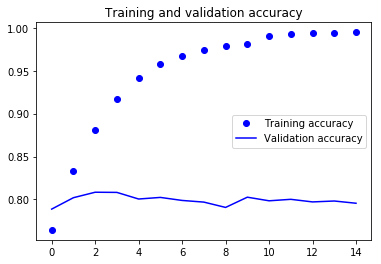

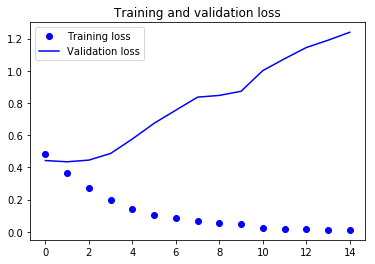

In [282]:
accuracy = quora_trained.history['acc']
val_accuracy = quora_trained.history['val_acc']
loss = quora_trained.history['loss']
val_loss = quora_trained.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

### Breaking the network to extract output of 128 feature maps from siamese function by creating a new model

First I load the model again which has both weights and model, then just save the weights.

In [34]:
quora = models.load_model('quora_lstm_max10.h5')

/users/aditya.sharma/super-resolution-master_new/SR_new/lib/python3.5/site-packages/keras/engine/topology.py:1231: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


In [35]:
quora.save_weights('quora_lstm_max10_weights.h5')

Next, I created a new model which takes two inputs and outputs two outputs, for each of the two questions it will output a feature map.

In [36]:
quora1 = Model([question1_input, question1_input], [encoded_q1,encoded_q2])

Then, I saved the combined model & weights and just weights file for this new model.

In [37]:
quora1.save('quora_lstm_max10_dense.h5')

In [38]:
quora1.save_weights('quora_lstm_max10_dense_weights.h5')

#### Training data predictions!

In [39]:
train_prediction = quora1.predict([train['question1'],train['question2']]) #training predictions

In [40]:
train_prediction = np.array(train_prediction) #converting the list of predictions into numpy array

In [41]:
train_prediction.shape

(2, 323429, 128)

Saving the predictions as a numpy array.

In [42]:
np.save('train_predictions.npy',train_prediction)

Since the output of `train_prediction` returns two predictions for `question1` and `question2`. I now reshape it to a one output which will have a shape `(2 X 323429,128)`

In [43]:
train_pred = np.reshape(train_prediction,(-1,128)) 

In [44]:
train_pred.shape

(646858, 128)

#### Validation data predictions!

In [177]:
val_prediction = quora1.predict([val['question1'],val['question2']]) #valid predictions

In [178]:
val_prediction = np.array(val_prediction) #converting the list of predictions into numpy array

In [179]:
val_prediction.shape

(2, 80858, 128)

In [180]:
np.save('val_predictions.npy',val_prediction)

In [181]:
val_pred = np.reshape(val_prediction,(-1,128)) 

In [182]:
val_pred.shape

(161716, 128)

Now, I use the `original_data` that I had defined in the starting and will append the `question2` with `question1` to make it one single column of data.

In [167]:
X_train, X_validation, Y_train, Y_validation = train_test_split(original_data,original_data.is_duplicate, random_state=13,test_size=0.2)

In [168]:
train_data = X_train.question1.append(X_train.question2)

In [169]:
train_data = train_data.reset_index()

In [170]:
train_data = train_data.drop(['index'], axis=1)

In [171]:
train_data.columns = ['questions']

In [172]:
train_data.shape

(646858, 1)

#### Validation dataframe

In [183]:
val_data = X_validation.question1.append(X_validation.question2)

In [184]:
val_data = val_data.reset_index()

In [185]:
val_data = val_data.drop(['index'], axis=1)

In [187]:
val_data.columns = ['questions']

In [188]:
val_data.shape

(161716, 1)

**Note:** I use 400K questions against which a query question will be compared.

Next, I divide the `train_pred` into two 400k and after 400K take 2K predictions as a query.

In [173]:
data_pred = train_pred

In [174]:
data_pred.shape

(646858, 128)

In [189]:
query_pred = val_pred

In [190]:
query_pred.shape

(161716, 128)

In [191]:
query_questions = val_data

In [192]:
query_questions.shape

(161716, 1)

In [175]:
data_questions = train_data

In [176]:
data_questions.shape

(646858, 1)

## Brute-Force Method for Finding the Top-3 Closest from the Training data for a given Input Query

In [212]:
import heapq

In [223]:
main_array = np.zeros((100,3))

In [224]:
def comparison(query):
    arr = []
    for i in range(data_pred.shape[0]):
            predict = np.linalg.norm(query - data_pred[i])
            arr.append(predict)
    hp = np.array(heapq.nsmallest(3, range(len(arr)), arr.__getitem__))
    return hp

I took only 100 query questions since this method takes 313 seconds to output top-3 suggestions for each input query time!

In [225]:
import time
start = time.clock()
for i in range(100):
    main_array[i,:] = comparison(query_pred[i])
print (time.clock() - start)   

313.1226750000005


In [226]:
main_array.shape

(100, 3)

In [227]:
np.set_printoptions(suppress=True)

In [228]:
main_array = main_array.astype(np.int64)

In [229]:
pd.set_option('display.max_colwidth', -1)

In [230]:
import csv
import os
filename = 'output_brute_force.csv'
a = open(filename, 'a')

headers = ['Query', 'Closest-1','Closest-2','Closest-3']
writer = csv.DictWriter(a, delimiter='\t', lineterminator='\n',fieldnames=headers)
fileEmpty = os.stat(filename).st_size == 0
writer.writeheader()
for i in range(len(main_array)):
    a.write((str(query_questions.iloc[i])).split('\n')[0].split('    ')[1]+'\t'+str(data_questions.iloc[main_array[i][0]]).split('\n')[0].split('    ')[1] +'\t'+ str(data_questions.iloc[main_array[i][1]]).split('\n')[0].split('    ')[1] +'\t'+ str(data_questions.iloc[main_array[i][2]]).split('\n')[0].split('    ')[1] + "\n")
a.close()    

In [274]:
data_brute = pd.read_csv('output_brute_force.csv',sep='\t')

In [275]:
data_brute.head()

,Query,Closest-1,Closest-2,Closest-3
0,What are the things that we can do to bring change in Indian education system?,What are the things that we can do to bring change in Indian education system?,What are the things that we can do to bring change in Indian education system?,What are the things that we can do to bring change in Indian education system?
1,Is Donald Trump in league with Putin?,Is Donald Trump in league with Putin?,Is Donald Trump in league with Putin?,What are some ways to contact Jesse Ventura?
2,What does Bootstrap do?,What is Kairos like?,What is frugal?,What's so special about Grana?
3,Why did Sanskrit fail to become a suitable language for computers?,Why did Sanskrit fail to become a suitable language for computers?,Why did Sanskrit fail to become a suitable language for computers?,Technology: Are we compromising on wisdom over information?
4,How can I increase my typing speed fast?,How can I increase my typing speed fast?,How can I increase my typing speed fast?,How can I increase my typing speed fast?


## Finding the Top-3 Closest from the Training data for a given Input Query using KMeans Clustering

To make the search space faster, I used KMeans clustering. Firstly, I trained Kmeans on the training data to get the cluster centers then predicted a cluster center for every new query. This improved the performance massively. Comparing to the brute-force method, Kmeans gave me top-3 results within `200secs` that too when I had not 100 but 1000 query questions against 650K questions and without any performance loss.

In [84]:
from sklearn.cluster import KMeans
import os

In [234]:
kmeans=KMeans(n_clusters=20, n_jobs=-1)

In [235]:
kmeans_fit = kmeans.fit(data_pred)

In [236]:
kmeans_fit.labels_

array([19,  7, 16, ..., 17, 15, 14], dtype=int32)

In [237]:
cluster_centers = kmeans.cluster_centers_

In [238]:
cluster_centers.shape

(20, 128)

In [239]:
kmeans_data_pred = kmeans.predict(data_pred)

In [240]:
kmeans_data_pred.shape

(646858,)

In [241]:
with open('kmeans_model.pickle', 'wb') as f:
     pickle.dump(kmeans_fit, f)

In [242]:
for i in range(20):
    index = np.where(kmeans_data_pred == i)
    np.array(cluster_centers[i]).dump(open('clusters/cluster_center[%s].npy' % i, 'wb'))

In [261]:
array = np.zeros((1000,3))

In [262]:
def compare(cluster,j):
    #print (cluster)
    assign = dict()
    a = np.where(kmeans_data_pred == cluster)[0]
    for i in a:
        dist = np.linalg.norm(query_pred[j] - data_pred[i])
        assign[i] = dist
    sorted_by_value = sorted(assign.items(), key=lambda kv: kv[1])
    a = [i for i, v in (sorted_by_value)]
    return (a[:3])

In [263]:
import time
start = time.clock()
for i in range(1000):
    array[i,:] = compare(kmeans.predict(query_pred[i].reshape(-1,128)),i)
print (time.clock() - start)    

201.52732800000013


In [265]:
array = array.astype(np.int64)

In [269]:
import csv
import os
filename = 'output_kmeans.csv'
a = open(filename, 'w')

headers = ['Query', 'Closest-1','Closest-2','Closest-3']
writer = csv.DictWriter(a, delimiter='\t', lineterminator='\n',fieldnames=headers)
fileEmpty = os.stat(filename).st_size == 0
writer.writeheader()

for i in range(len(array)):
    a.write((str(query_questions.iloc[i])).split('\n')[0].split('    ')[1] + '\t' + str(data_questions.iloc[array[i][0]]).split('\n')[0].split('    ')[1] + '\t' + str(data_questions.iloc[array[i][1]]).split('\n')[0].split('    ')[1] + '\t' + str(data_questions.iloc[array[i][2]]).split('\n')[0].split('    ')[1] + "\n")
a.close()    

In [272]:
data_kmeans = pd.read_csv('output_kmeans.csv',sep='\t')

In [273]:
data_kmeans.head()

,Query,Closest-1,Closest-2,Closest-3
0,What are the things that we can do to bring change in Indian education system?,What are the things that we can do to bring change in Indian education system?,What are the things that we can do to bring change in Indian education system?,What are the things that we can do to bring change in Indian education system?
1,Is Donald Trump in league with Putin?,Is Donald Trump in league with Putin?,Is Donald Trump in league with Putin?,What are some ways to contact Jesse Ventura?
2,What does Bootstrap do?,What is Kairos like?,What is frugal?,What is a Discord chat?
3,Why did Sanskrit fail to become a suitable language for computers?,Why did Sanskrit fail to become a suitable language for computers?,Why did Sanskrit fail to become a suitable language for computers?,Technology: Are we compromising on wisdom over information?
4,How can I increase my typing speed fast?,How can I increase my typing speed fast?,How can I increase my typing speed fast?,How can I increase my typing speed fast?
